In [127]:
import os
import sys

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as img 
import seaborn as sns
%matplotlib inline

In [128]:
data = pd.read_excel("daily_tracking.xlsx", sheet_name='weight', header=1)

In [129]:
data.head()

,Date,Weeks,avg,std,Thu,Fri,Sat,Sun,Mon,Tue,Wed,Change Reason
0,2019-01-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-17,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-24,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-02-07,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
data.columns

Index(['Date', 'Weeks', 'avg', 'std', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue',
       'Wed', 'Change Reason'],
      dtype='object')

In [131]:
# weight curve frequency -- daily/weekly/monthy
freq = 1

In [132]:
date_cols = ['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed']
date_maps = {c: i for i, c in enumerate(date_cols)}

In [133]:
new_data = data[['Date'] + date_cols].rename(columns=date_maps)
new_data.columns

Index(['Date', 0, 1, 2, 3, 4, 5, 6], dtype='object')

In [134]:
# transpose data
new_data_l = new_data.melt(id_vars='Date', value_vars=date_maps.values(), 
              value_name='weight', var_name='prenatal_weekday')

In [135]:
new_data_l = new_data_l.sort_values(by = ['Date', 'prenatal_weekday'], 
                       ascending=[True, True])
new_data_l['calendar_date'] = new_data_l[['Date', 'prenatal_weekday']].apply(
    lambda x: x[0] + timedelta(x[1]), axis=1)
new_data_l = new_data_l.rename(columns={'Date': 'prenatal_week_s'})

In [136]:
new_data_l['calendar_weekday'] = new_data_l['calendar_date'].dt.dayofweek

In [137]:
new_data_l.index = new_data_l['calendar_date']
# new_data_l.drop('calendar_date', axis=1, inplace=True)
new_data_l.head()

,prenatal_week_s,prenatal_weekday,weight,calendar_date,calendar_weekday
calendar_date,,,,,
2019-01-10,2019-01-10,0,NaN,2019-01-10,3
2019-01-11,2019-01-10,1,NaN,2019-01-11,4
2019-01-12,2019-01-10,2,NaN,2019-01-12,5
2019-01-13,2019-01-10,3,NaN,2019-01-13,6
2019-01-14,2019-01-10,4,NaN,2019-01-14,0


In [138]:
new_data_l['prenatal_week_no'] = new_data_l.groupby(['prenatal_week_s']).ngroup()
# new_data_l['prenatal_months']
new_data_l.max()

prenatal_week_s     2019-11-14 00:00:00
prenatal_weekday                      6
weight                               61
calendar_date       2019-11-20 00:00:00
calendar_weekday                      6
prenatal_week_no                     44
dtype: object

In [139]:
# sns.set(style="white")
new_data_l.loc['2019-07-24']

prenatal_week_s     2019-07-18 00:00:00
prenatal_weekday                      6
weight                             56.7
calendar_date       2019-07-24 00:00:00
calendar_weekday                      2
prenatal_week_no                     27
Name: 2019-07-24 00:00:00, dtype: object

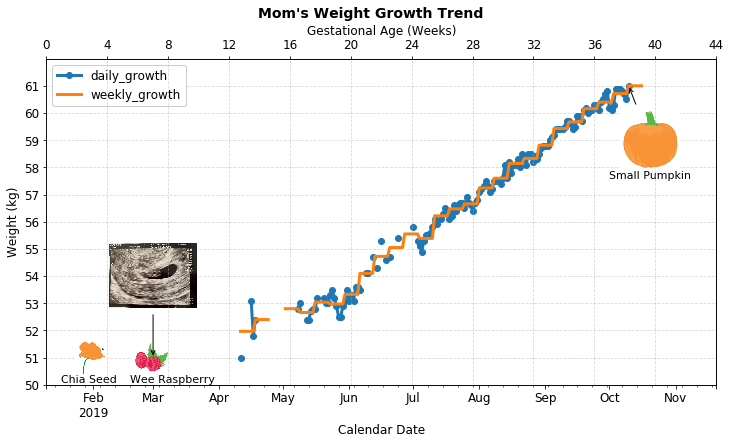

In [206]:
# daily growth
new_data_l['weight'].plot(kind='line',
                          figsize=(12, 8),
                          ylim=[50, 60], 
                          xlim=[new_data_l.index[0], new_data_l.index[-1]],
                          fontsize=12,
                          yticks=range(50, 61, 1),
                          xticks=pd.date_range(start='2019-1-10', end='2019-10-17', freq='7D'),
                          label='daily_growth',
                          linewidth=3,
                          marker='o',
                          )
ax = plt.gca()
# weekly growth by mean value
new_data_l['weekly_mean'] = new_data_l.groupby(
    'prenatal_week_s')['weight'].transform(np.mean)
new_data_l['weekly_mean'].plot(kind='line',
                              figsize=(12, 6),
                              ylim=[50, 62], 
                              xlim=[new_data_l.index[0], new_data_l.index[-1]],
                              fontsize=12,
                              yticks=range(50, 62, 1),
                              label='weekly_growth',
                              linewidth=3,
#                               marker='x',
                              ax=ax
                          )
# overall settings
ax.legend(fontsize=12)
ax.set_xlabel('Calendar Date', fontsize=12)
ax.set_ylabel('Weight (kg)', fontsize=12)
# ax.grid()
ax.yaxis.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=1)

ax2 = ax.twiny()
ax2.set_xticks(range(0, new_data_l['prenatal_week_no'].max() + 4, 4))
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel('Gestational Age (Weeks)', fontsize=12)
ax2.xaxis.grid(linestyle='--', alpha=0.5)

# insert pictures
special_dates = ['2019-01-31', '2019-02-28', '2019-03-01', '2019-10-10']
names = ['Chia Seed', 'Wee Raspberry', 'Wee Raspberry', 'Small Pumpkin']
zoom_ratio = [0.08, 0.1, 0.15, 0.15]
pos_adj_y = [0, 0, 3, -2]
pos_adj_x = [0, 0, 0, 10]
text_adj_y = [-0.8, -0.8, -0.8, -3.3]
text_adj_x = [-1, 10, -1, 10]
for special_date, name, ratio, pos_x, pos_y, text_pos_x, text_pos_y in zip(
    special_dates, names, zoom_ratio, pos_adj_x, pos_adj_y, text_adj_x, text_adj_y):
    w = new_data_l.loc[special_date, 'weight']
    if np.isnan(w):
        w = 51 # fill na
    preg_pic = img.imread('%s.jpg' % special_date)
    imagebox = OffsetImage(preg_pic, zoom=ratio)
    special_date_np = datetime.strptime(special_date, '%Y-%m-%d')
    bbox_pos = (special_date_np + timedelta(pos_x), w + pos_y)
    ab = AnnotationBbox(imagebox, xy=(special_date, w), 
                        xybox=bbox_pos,
                        xycoords='data',
                        boxcoords=("data", "data"),
                        frameon=False,
                        bboxprops=dict(edgecolor=None, facecolor=None),
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    if special_date == '2019-03-01':
        pass
    else:
        ax.annotate(name, xy=(special_date, w), 
                    xytext=(special_date_np + timedelta(text_pos_x), 
                            w+text_pos_y),
                    color="black", fontsize=11, va='center', ha='center'
#                     arrowprops=dict(facecolor='black', shrink=0.05)
#                     bbox=dict(edgecolor=None, facecolor='white')
                   )

fig = plt.gcf()
fig.suptitle("Mom's Weight Growth Trend", 
             x=0.5, y=1, fontsize=14, fontweight='bold')
# fig.subplots_adjust(top=0.85)
fig.savefig("mom_weight_growth.png")

plt.show()